In [1]:
import logging, sys
LOG_LEVEL = logging.INFO
logging.basicConfig(filename='current.log',encoding='utf-8',level=LOG_LEVEL, filemode = 'w', format='%(asctime)s-%(levelname)s: Process %(process)d said: %(message)s')
log = logging.getLogger()
log.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['NUMEXPR_MAX_THREADS'] = '256'

import tensorflow as tf

## Check if Tensorflow really runs on your GPU
# refer first to the README (!), then to this article, especially if you are using a windows machine https://www.tensorflow.org/install/pip#windows-wsl2_1
#tf_config = tf.config.list_physical_devices('GPU')
#logging.debug("Num GPUs Available: {}".format(len(tf.config.list_physical_devices('GPU'))))
#logging.debug(tf_config)
    
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     #tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
#     logging.debug(tf.config.experimental.set_memory_growth(gpus[0], True))
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     logging.debug((len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs"))
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     logging.debug(e)


2024-04-11 01:49:19.007222: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-04-11 01:49:20.970595: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-11 01:49:21.010110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 44.53GiB deviceMemoryBandwidth: 804.75GiB/s
2024-04-11 01:49:21.010146: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-04-11 01:49:21.014596: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-04-11 01:49:21.014648: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

In [3]:
#HACK fix import and order
from skimage import exposure, io
from flowdec import data as tfd_data
from flowdec import psf as tfd_psf
from flowdec import restoration as tfd_restoration
from skimage.transform import rescale
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from pprint import pprint

#from FOV import FOV

%matplotlib inline

In [4]:
# Microscope Parameters from the Arctis 100x iFLM
# Image properties
# Size of the PSF array, pixels
size_x = 256
size_y = 256
size_z = 128
#
# # Microscope parameters
NA          = 0.9
wavelength  = 0.588 # microns
M           = 100   # magnification
ns          = 1.0  # specimen refractive index (RI)
ng0         = 1.0   # coverslip RI design value
ni0         = 1.0   # immersion medium RI design value
ti0         = 3000   # microns, working distance (immersion medium thickness) design value
tg0         = 0   # microns, coverslip thickness design value
res_lateral = 0.075   # microns
res_axial   = 0.25  # microns

# ng          = 1.5   # coverslip RI experimental value (defaults to ng0 if not given)
# ni          = 1.5   # immersion medium RI experimental value (defaults to ni0 if not given)
# tg          = 170   # microns, coverslip thickness experimental value (defaults to tg0 if not given)
# pZ          = 2     # microns, particle distance from coverslip
#
# # Precision control
# num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
# num_samples  = 1000 # Number of pupil samples along radial direction
# oversampling = 2    # Defines the upsampling ratio on the image space grid for computations

In [5]:
# Set directory of image stack
# sudo mount -t drvfs '//samba-pool-pool-plitzko3.biochem.mpg.de/pool-plitzko3' /mnt/plitzko3
file_pattern = '/fs/pool/pool-plitzko3/Johann/03-Data/04-LightMicroscopy/EMBO_course_decon_testing/RAGE_01.lif'#

#'/fs/pool/pool-pub/EMBO/FLM/PreImaged_Yeast/20240402_Yeast_CA_GE_05/CA_GE_05_tiles.lif'
output_folder = '/fs/pool/pool-plitzko3/Johann/03-Data/04-LightMicroscopy/EMBO_course_decon_testing/'
#'/fs/pool/pool-pub/EMBO/FLM/PreImaged_Yeast/20240402_Yeast_CA_GE_05/'#
LIFFILE = True
logging.info("Current File: {}".format(file_pattern))

Current File: /fs/pool/pool-plitzko3/Johann/03-Data/04-LightMicroscopy/EMBO_course_decon_testing/RAGE_01.lif


In [6]:
import pandas as pd
import numpy as np
from readlif.reader import LifFile
from readlif.utilities import get_xml
import xmltodict


# @HACK Add a parameter to select for a certain name
class FOV:
    def __init__(self,lif_path, FOV_num):
        self.FOV_num = FOV_num
        self.lif_path = lif_path

        self.parse_lif_header(lif_path)

        tilescans=[]         # @TODO find tilescan with Pos or FOV
        if type(self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element']) is list:
            self.multiAcquisitionFile = True
            for i, el in enumerate(self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element']):
                if 'TileScan' in el['@Name']:
                    tilescans.append([i,el])
        else: 
            self.multiAcquisitionFile = False
            tilescans.append([0,self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element']['@Name']]) 

        if len(tilescans) > 1:  # @TODO check for Pos or FOV string            
            for el in tilescans:
                if ('Pos' in self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element'][el[0]]['Children']['Element'][0]['@Name']) or \
                ('FOV' in self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element'][el[0]]['Children']['Element'][0]['@Name']):
                    self.tileset_index = el[0]
                    break
        elif len(tilescans) == 1:
            self.tileset_index = tilescans[0][0]
        else:
            Exception("Error, I couldn't detect any TileScans containing 'FOV' or 'Pos'")

        self.FOV_count = self.get_FOV_count()
        if self.multiAcquisitionFile:
            self.selected_FOV = self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element'][self.tileset_index]['Children']['Element'][FOV_num]
        else:            
            self.selected_FOV = self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element']['Children']['Element'][FOV_num]

        for i in range(len(self.selected_FOV['Data']['Image']['Attachment'])):
            if 'ATLConfocalSettingDefinition' in self.selected_FOV['Data']['Image']['Attachment'][i]:
                self.attachment_num = i
                break

        microscope_params = self.selected_FOV['Data']['Image']['Attachment'][self.attachment_num]['ATLConfocalSettingDefinition'] #Small helper for dict depth
        self.FOV_name = self.selected_FOV['@Name']
        self.NA = float(microscope_params['@NumericalAperture'])
        self.mag = float(microscope_params['@Magnification'])
        self.StagePosX = float(microscope_params['@StagePosX'])
        self.StagePosY = float(microscope_params['@StagePosY'])
        self.pinholeAiry = float(microscope_params['@PinholeAiry'])
        self.zoom = float(microscope_params['@Zoom'])
        self.stack_sections = float(microscope_params['@Sections'])

        resolution_params = self.selected_FOV['Data']['Image']['ImageDescription']['Dimensions']['DimensionDescription']
        self.channel_order = microscope_params['@ScanMode']
        self.resolution = pd.DataFrame({'dimension_name': None, 'dimension_number': None, 'pixels': None, 'length': None, 'unit': None, 'resolution_nm': None}, index=[0])
        for dim in range(len(resolution_params)):
            self.resolution.loc[dim,'dimension_number'] = int(resolution_params[dim]['@DimID'])
            self.resolution.loc[dim,'dimension_name']= self.channel_order[self.resolution.loc[dim,'dimension_number'] - 1]
            self.resolution.loc[dim,'pixels'] = int(resolution_params[dim]['@NumberOfElements'])
            self.resolution.loc[dim,'length'] = float(resolution_params[dim]['@Length'])
            self.resolution.loc[dim,'unit'] = resolution_params[dim]['@Unit']
            if self.resolution.loc[dim,'unit']  == 'm':
                self.resolution.loc[dim,'resolution_nm'] = float(self.resolution.loc[dim,'length']) / int(self.resolution.loc[dim,'pixels']) * 1e9




        self.microscope = self.selected_FOV['Data']['Image']['Attachment'][self.attachment_num]['@SystemTypeName']
        if self.microscope == 'TCS SP8':
            self.working_distance_mm = 0.28
        
        self.fluo_channels = 0
        self.set_channels(microscope_params)

        self.lif_file = LifFile(lif_path) # @TODO wrap with execption handler

        del self.param_dict

        
        
    def get_channel_stack(self,channel_num=0,all_channels=False):
        self.lif_stack = self.lif_file.get_image(self.tileset_index + self.FOV_num)
        if all_channels:
            return np.array([[np.array(i) for i in self.lif_stack.get_iter_z(t=0, c=chan)] for chan in range(self.lif_stack.channels)])
        else:
            return np.array([np.array(i) for i in self.lif_stack.get_iter_z(t=0, c=channel_num)])

    def get_FOV_count(self):
        if self.multiAcquisitionFile:
            return len(self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element'][self.tileset_index]['Children']['Element'])
        else:
            return len(self.param_dict['LMSDataContainerHeader']['Element']['Children']['Element']['Children']['Element'])

    def parse_lif_header(self,lif_path=None):
        if lif_path is not None:
            lif_path = self.lif_path
        self.param_xml = get_xml(lif_path)
        self.param_dict = xmltodict.parse(self.param_xml[1])
        return self.param_dict
    
    def set_channels(self,FOV_params):
            self.channels = [{'number': 0,
                              'name': "",
                              'scan_type': '',
                              'dye_preset': '',
                              'detection_window': ''
                              } for i in range(len(FOV_params['DetectorList']['Detector']))]
            for c in range(len(FOV_params['DetectorList']['Detector'])):
                chan_params = dict(FOV_params['DetectorList']['Detector'][c])
                self.channels[c]['number'] = c
                self.channels[c]['name'] = chan_params['@Name'] 
                self.channels[c]['scan_type'] = chan_params['@ScanType']    
                self.channels[c]['gain'] = float(chan_params['@Gain'])
                if chan_params['@ScanType']  == 'Internal':
                    self.fluo_channels += 1

            for b in range(len(FOV_params['Spectro']['MultiBand'])):
                if type(FOV_params['Spectro']['MultiBand'][b]) is dict:
                    ind = int(FOV_params['Spectro']['MultiBand'][b]['@Channel'])-1
                    self.channels[ind]['dye_preset'] = FOV_params['Spectro']['MultiBand'][b]['@DyeName']
                    self.channels[ind]['detection_window'] = (float(FOV_params['Spectro']['MultiBand'][b]['@LeftWorld']), float(FOV_params['Spectro']['MultiBand'][b]['@RightWorld']))
                    self.channels[ind]['center_wavelength'] = (self.channels[ind]['detection_window'][1] + self.channels[ind]['detection_window'][0]) / 2
                    
    def print(self):
        try:
            from pprint import pprint
            pprint(vars(self))
            return(vars(self))
        except ImportError as e:            
            print(vars(self))

In [7]:
# Import LIF data with a custom written handler class here
# FIXME Comment class properly
#HACK Loop over all FOVs
#HACK handle exceptions in class
#TODO calibrate images
#TODO in the very future optimize import, this takes ages!!!
#TODO map to overview


if LIFFILE:
    test_fov = FOV(file_pattern,0)
    logging.info(test_fov.FOV_name)

Pos_01


In [8]:
#HACK loop over channels
if LIFFILE:
    test_stack = test_fov.get_channel_stack(channel_num=0)
    logging.debug(test_stack.shape)

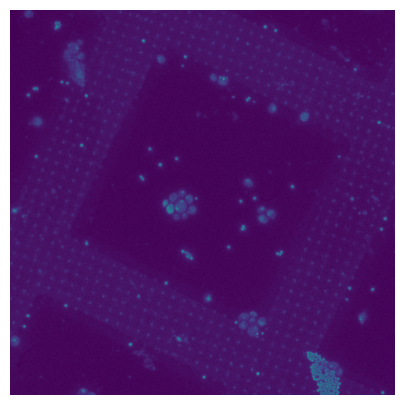

In [9]:
# %%
if LIFFILE:
    if len(test_stack.shape) == 4:
        num = test_stack.shape[0]
    else:
        num = 1
    fig,ax = plt.subplots(1,num, figsize=(15,5))
    for chan in range(num):
        if num == 1:
            ax.imshow(np.max(test_stack,axis=0))
            ax.axis('off')
        else:
            ax[chan].imshow(np.max(test_stack[chan],axis=0))
            ax[chan].axis('off')

In [10]:
# Load image stack for debugging
if not LIFFILE:
    stack = io.imread('input.tif', plugin="tifffile")
else:    
    if len(test_stack.shape) == 4:
        stack = test_stack[0]
    else:
        stack = test_stack
logging.info('Input stack shape: {}, dtype: {}'.format(stack.shape,stack.dtype))

Input stack shape: (39, 2048, 2048), dtype: uint8


In [11]:
scalexy, scalez = 1, 1
if np.max(scalexy) == 1 and np.max(scalez) == 1:
    stack_scaled = stack
else:
    stack_scaled = rescale(stack, (scalez,scalexy,scalexy), mode='constant', order=2, anti_aliasing=True) 
logging.debug(stack_scaled.shape)

In [12]:
# This is meant to be representative of the arctis 100x widefield image capture (all distance units are in microns)
'''
psf = np.zeros_like(stack_scaled)
psf = tfd_psf.GibsonLanni(
    na=NA,           # Numerical aperture
    m=M,             # Magnification
    ni0=ni0,         # Immersion RI
    res_lateral=res_lateral, # X/Y resolution
    res_axial=res_axial,     # Axial resolution
    wavelength=wavelength,  # Emission wavelength 
    size_x=np.max((size_x, int(stack_scaled.shape[2]))), 
    size_y=np.max((size_y, int(stack_scaled.shape[1]))), 
    size_z=np.min((size_z, int(stack_scaled.shape[0]))),
    ns = ns,
    ng0 = ng0,
    ti0 = ti0,
    tg0 = tg0,
).generate()
logging.debug((psf.shape, psf.dtype))
'''

'\npsf = np.zeros_like(stack_scaled)\npsf = tfd_psf.GibsonLanni(\n    na=NA,           # Numerical aperture\n    m=M,             # Magnification\n    ni0=ni0,         # Immersion RI\n    res_lateral=res_lateral, # X/Y resolution\n    res_axial=res_axial,     # Axial resolution\n    wavelength=wavelength,  # Emission wavelength \n    size_x=np.max((size_x, int(stack_scaled.shape[2]))), \n    size_y=np.max((size_y, int(stack_scaled.shape[1]))), \n    size_z=np.min((size_z, int(stack_scaled.shape[0]))),\n    ns = ns,\n    ng0 = ng0,\n    ti0 = ti0,\n    tg0 = tg0,\n).generate()\nlogging.debug((psf.shape, psf.dtype))\n'

In [13]:
if LIFFILE:
    psf_var = tfd_psf.GibsonLanni(
        na          = test_fov.NA,                           # Numerical aperture
        m           = test_fov.mag,                          # Magnification
        ni0         = 1.0,                                   # Immersion RI
        res_lateral = float(test_fov.resolution[test_fov.resolution['dimension_name'] == 'x']['resolution_nm'].values[0] / 1000) , # X/Y resolution
        res_axial   = float(test_fov.resolution[test_fov.resolution['dimension_name'] == 'z']['resolution_nm'].values[0] / 1000), # Axial resolution
        wavelength  = float(test_fov.channels[0]['center_wavelength'] / 1000),  # Emission wavelength 
        size_x      = int(np.max((size_x, int(stack_scaled.shape[2])))), 
        size_y      = int(np.max((size_y, int(stack_scaled.shape[1])))), 
        size_z      = int(np.min((size_z, int(stack_scaled.shape[0])))),
        ns          = 1.0,                                     # specimen refractive index (RI)
        ng0         = 1.0,                                     # Refractive index of coverslip
        ti0         = float(test_fov.working_distance_mm * 1000),     # microns, working distance (immersion medium thickness) design value
        tg0         = 0,                                     # microns, coverslip thickness design value
    )
    psf_var.save('./current_psf.json')
    psf = psf_var.generate().astype(np.uint8)
    logging.info('PSF shape: {}, PSF dtype: {}'.format(psf.shape, psf.dtype))
    logging.info('PSF: ' + psf_var.to_json())

PSF shape: (39, 2048, 2048), PSF dtype: uint8
PSF: {"size_x": 2048, "size_y": 2048, "size_z": 39, "na": 0.9, "wavelength": 0.5115, "m": 52.5, "ns": 1.0, "ng0": 1.0, "ng": null, "ni0": 1.0, "ni": null, "ti0": 280.0, "tg0": 0, "tg": null, "res_lateral": 0.084748486328125, "res_axial": 0.29250256410256414, "pz": 0, "num_basis": 100, "num_samples": 1000, "oversampling": 2, "min_wavelength": 0.436}
PSF: {"size_x": 2048, "size_y": 2048, "size_z": 39, "na": 0.9, "wavelength": 0.5115, "m": 52.5, "ns": 1.0, "ng0": 1.0, "ng": null, "ni0": 1.0, "ni": null, "ti0": 280.0, "tg0": 0, "tg": null, "res_lateral": 0.084748486328125, "res_axial": 0.29250256410256414, "pz": 0, "num_basis": 100, "num_samples": 1000, "oversampling": 2, "min_wavelength": 0.436}


In [14]:
# This is meant to be representative of the Leica SP8 50x widefield image capture (all distance units are in microns)
# %%
# This is meant to be representative of the Leica SP8 50x widefield image capture (all distance units are in microns)
if not LIFFILE:
    psf = np.zeros_like(stack_scaled)
    psf = tfd_psf.GibsonLanni(
        na=0.9,           # Numerical aperture
        m=52.5,             # Magnification
        ni0=ni0,         # Immersion RI
        res_lateral=0.085, # X/Y resolution
        res_axial=0.3,     # Axial resolution
        wavelength=0.58,  # Emission wavelength 
        size_x=np.max((size_x, int(stack_scaled.shape[2]))), 
        size_y=np.max((size_y, int(stack_scaled.shape[1]))), 
        size_z=np.min((size_z, int(stack_scaled.shape[0]))),
        ns          = 1,                                     # specimen refractive index (RI)
        ng0         = 1,                                     # Refractive index of coverslip
        ti0         =  280,     # microns, working distance (immersion medium thickness) design value
        tg0 = tg0,
    ).generate()
    logging.info((psf.shape, psf.dtype))

In [15]:
# In case your GPU setup allows for a continuous oberserver or saving of intermediate steps (requires more memory, and is not used here)
imgs = []
scores = {}
def observer(img, i, *args):
    imgs.append(img)
    scores[i] = {
    'mse': mean_squared_error(stack_scaled, img),
    #'ssim': structural_similarity(stack_scaled, img, data_range=1), #@TODO find out why SSIM doesn't work as expected
    'psnr': peak_signal_noise_ratio(stack_scaled, img)
    }
    
    if i % 1 == 0:
        if i == 1:
            logging.info('Observing iteration = {} (dtype = {}, max = {:.3f})'.format(i, img.dtype, img.max()))        
        else:            
            #logging.info('Observing iteration = {} (MSE = {:.2f},SSIM = {:.2f}, PSNR = {:.2f})'.format(i, scores[i]['mse'],scores[i]['ssim'],scores[i]['psnr']))        
            logging.info('Observing iteration = {} (MSE = {:.2f}, PSNR = {:.2f})'.format(i, scores[i]['mse'],scores[i]['psnr']))        


acq = tfd_data.Acquisition(stack_scaled.astype(np.uint8),psf.astype(np.uint8))
logging.info(acq.shape())

{'data': (39, 2048, 2048), 'kernel': (39, 2048, 2048), 'actual': None}


In [16]:
# Run the deconvolution process and note that deconvolution initialization is best kept separate from 
# execution since the "initialize" operation corresponds to creating a TensorFlow graph, which is a 
# relatively expensive operation and should not be repeated across multiple executions
#
# In case you experience CUDA memory errors, remove the observer and add pad_mode='none'

channels = 0
niter = 100
logging.info("Starting GPU decon!")
algo = tfd_restoration.RichardsonLucyDeconvolver(n_dims=3,observer_fn=observer).initialize()
res = algo.run(acq, niter=niter)
logging.info("Finished successfully!")

Starting GPU decon!


2024-04-11 01:49:27.935464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 01:49:27.987080: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2446140000 Hz
2024-04-11 01:49:28.007201: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7a5cc60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-11 01:49:28.007285: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-11 01:49:28.124991: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x51edd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-11 

Observing iteration = 1 (dtype = float32, max = 221.250)
Observing iteration = 2 (MSE = 6.98, PSNR = 39.69)
Observing iteration = 3 (MSE = 7.73, PSNR = 39.25)
Observing iteration = 4 (MSE = 8.65, PSNR = 38.76)
Observing iteration = 5 (MSE = 9.56, PSNR = 38.33)
Observing iteration = 6 (MSE = 10.36, PSNR = 37.98)
Observing iteration = 7 (MSE = 11.02, PSNR = 37.71)
Observing iteration = 8 (MSE = 11.58, PSNR = 37.50)
Observing iteration = 9 (MSE = 12.04, PSNR = 37.33)
Observing iteration = 10 (MSE = 12.42, PSNR = 37.19)
Observing iteration = 11 (MSE = 12.75, PSNR = 37.07)
Observing iteration = 12 (MSE = 13.04, PSNR = 36.98)
Observing iteration = 13 (MSE = 13.29, PSNR = 36.90)
Observing iteration = 14 (MSE = 13.51, PSNR = 36.82)
Observing iteration = 15 (MSE = 13.70, PSNR = 36.76)
Observing iteration = 16 (MSE = 13.88, PSNR = 36.71)
Observing iteration = 17 (MSE = 14.04, PSNR = 36.66)
Observing iteration = 18 (MSE = 14.18, PSNR = 36.61)
Observing iteration = 19 (MSE = 14.31, PSNR = 36.57)
O

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

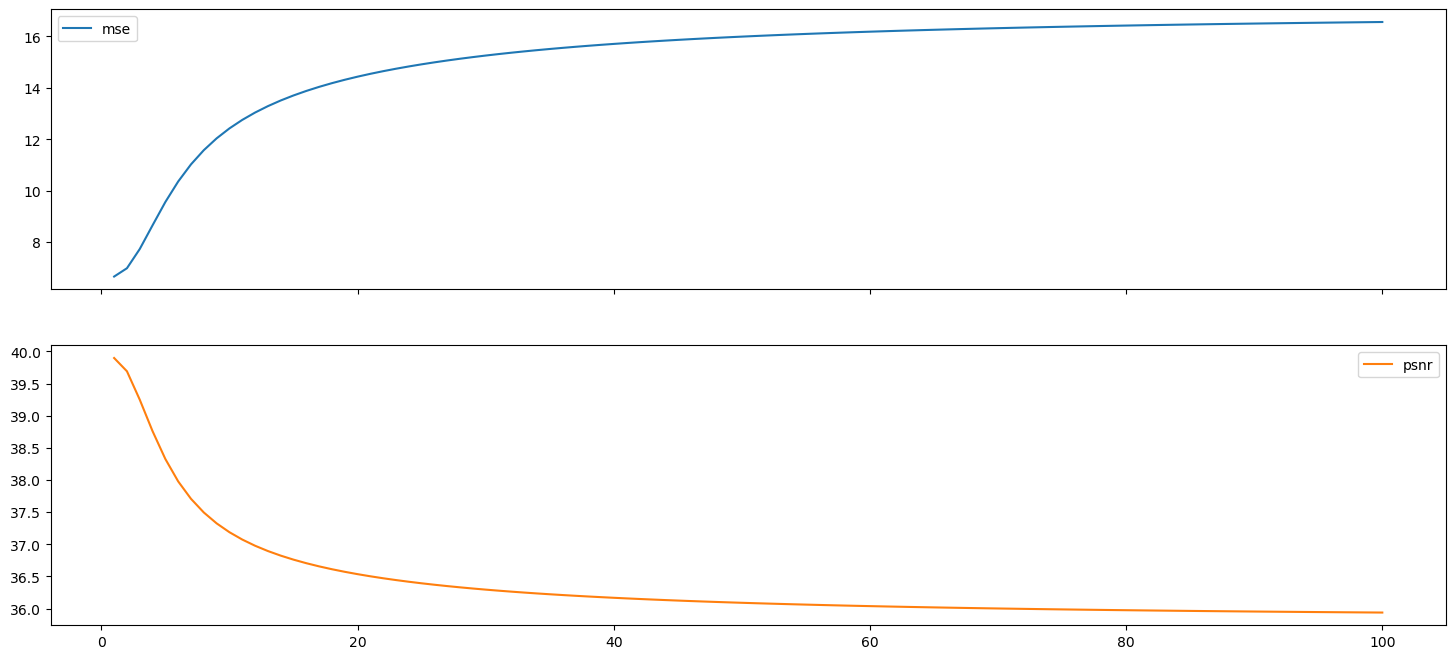

In [17]:
import pandas as pd
pd.DataFrame(scores).T.plot(subplots=True, figsize=(18, 8))

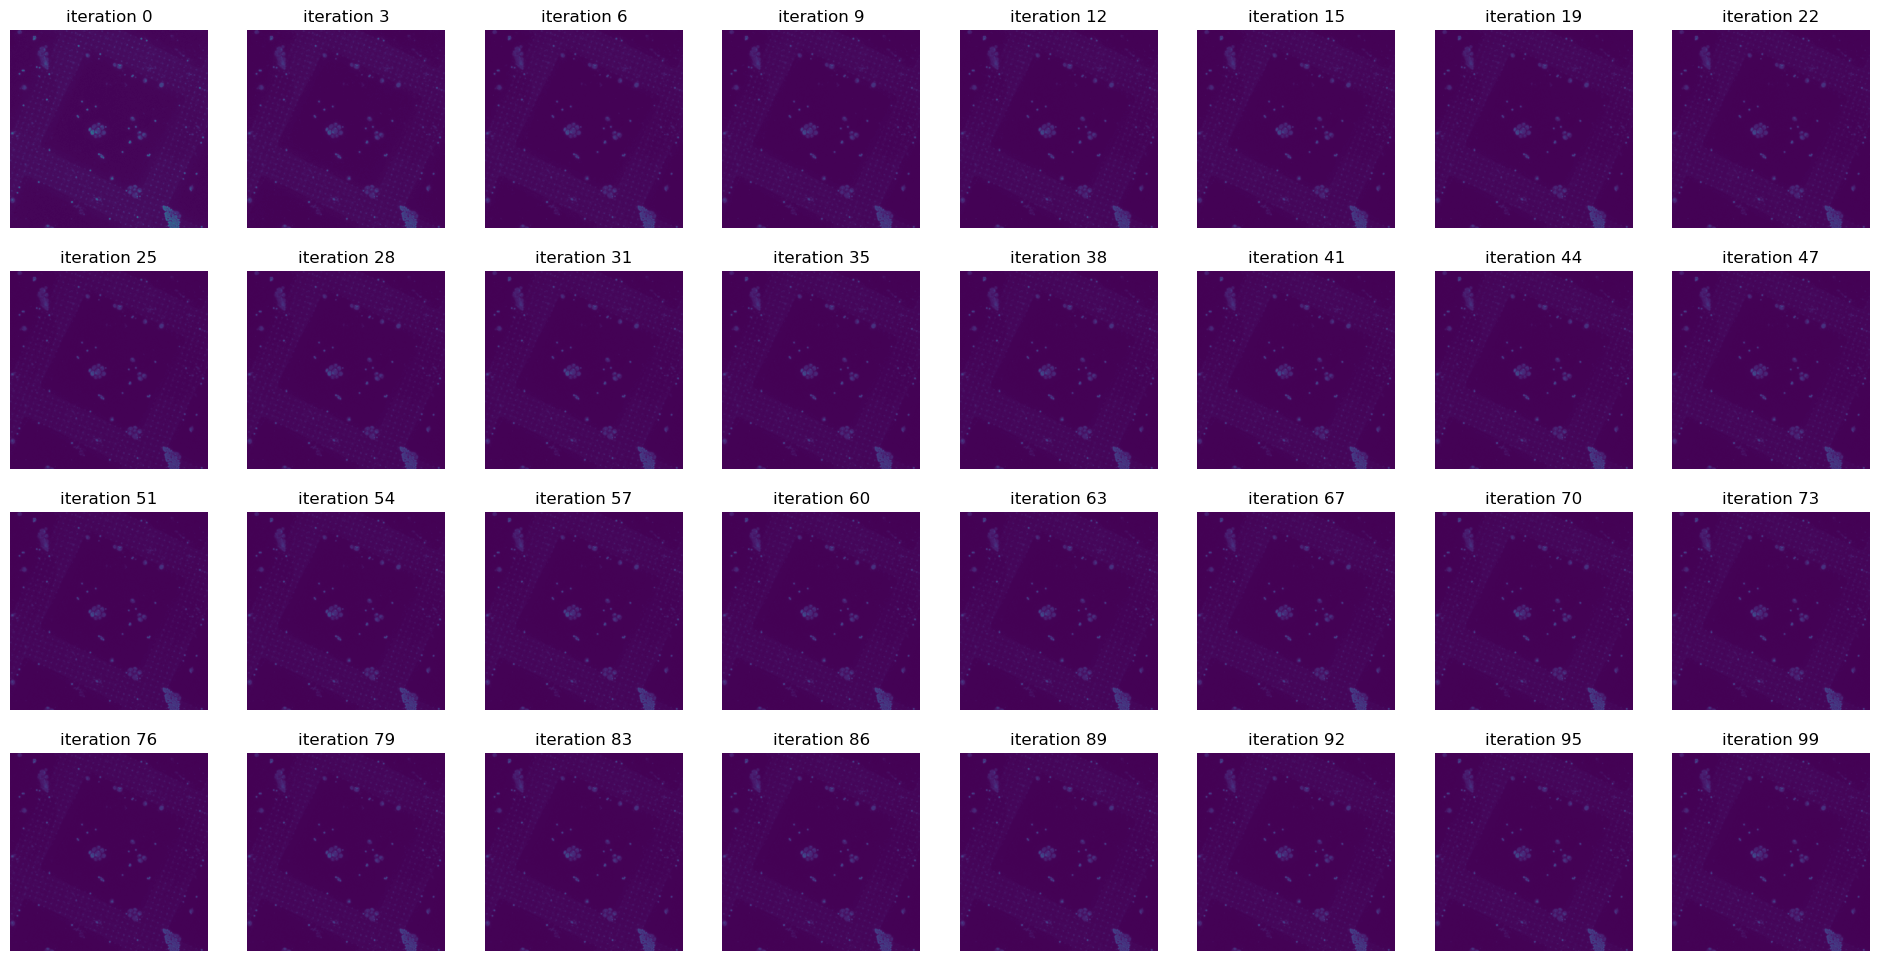

In [18]:
# Visualize the iterations
n = 32
iters = np.linspace(0, niter-1, num=n).astype(int)
fig, axs = plt.subplots(4, 8)
axs = axs.ravel()
fig.set_size_inches(24, 12)
for i, j in enumerate(iters):
    axs[i].axis('off')
    axs[i].set_title('iteration {}'.format(j))
    axs[i].imshow(imgs[j].max(axis=0))

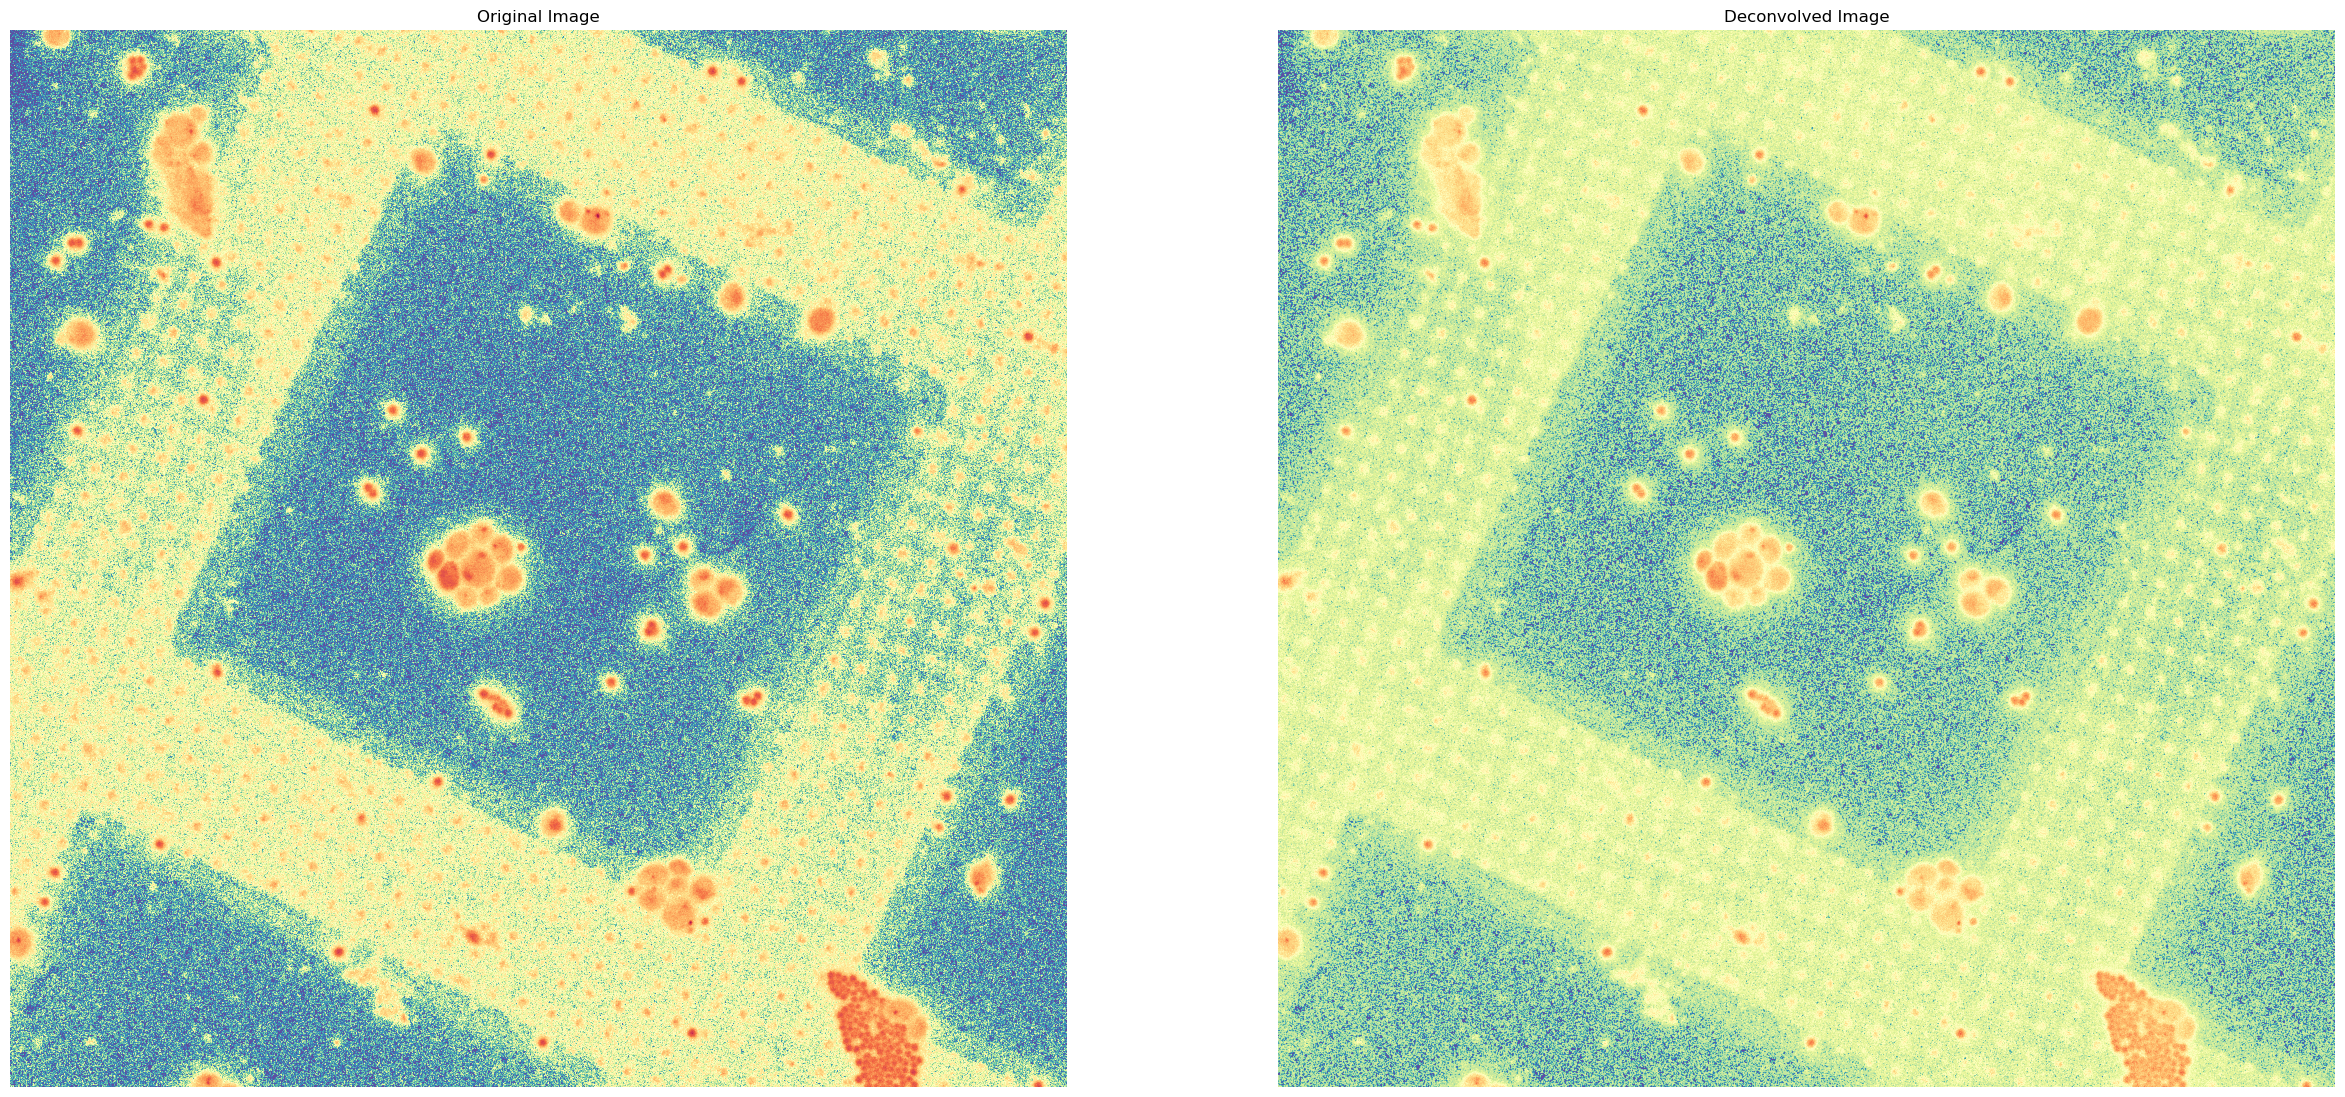

In [19]:
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(30, 15)
center = tuple([slice(None), slice(10, -10), slice(10, -10)])
titles = ['Original Image', 'Deconvolved Image']
for i, d in enumerate([stack_scaled, res.data ]):#res.data
    img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

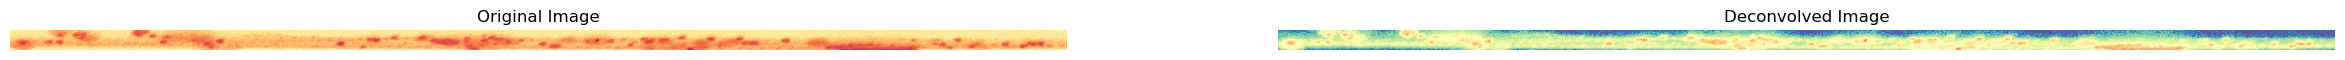

In [20]:
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(30, 30)
xz_projection_data = np.max(stack_scaled, axis=1)
xz_projection_decon = np.max(res.data, axis=1)
titles = ['Original Image', 'Deconvolved Image']
for i, d in enumerate([xz_projection_data, xz_projection_decon]):#res.data
    img = exposure.adjust_gamma(d,gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

In [21]:
# Function to plot a selectable image from the stack

def plot_image(i):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.imshow(exposure.adjust_gamma(stack_scaled[i, slice(10, -10), slice(10, -10)],gamma=.2), cmap='Spectral_r')#)'gray'
    ax2.imshow(exposure.adjust_gamma(res.data[i, slice(10, -10), slice(10, -10)],gamma=.2), cmap='Spectral_r')#'Spectral_r')'gray'
    ax2.axis('off')
    fig.show()

# Create a slider widget
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=res.data.shape[0] - 1,
    step=1,
    description='Image Index:',
    continuous_update=True
)

widgets.interactive(plot_image, i=slider) # Create an interactive widget

interactive(children=(IntSlider(value=0, description='Image Index:', max=38), Output()), _dom_classes=('widget…

In [22]:
if LIFFILE:
    from datetime import datetime    
    io.imsave(output_folder + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_deconv.tif',res.data.astype(np.float16))
    io.imsave(output_folder + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_input.tif',stack_scaled)

    io.imsave('./' + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_deconv.tif',res.data.astype(np.float16))
    io.imsave('./' + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_input.tif',stack_scaled)



    io.imsave('./' + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_MIP_deconv.tif',np.max(res.data.astype(np.float16),axis=0))
    io.imsave('./' + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_MIP_input.tif',np.max(stack_scaled,axis=0))
